In [273]:
import networkx as nx
import numpy as np
import math
from ipywidgets import widgets
import matplotlib.pyplot as plt
import seaborn as sns

In [274]:
# Parameters

# dataset = 'infectious'
# beta = 1
# Delta_T = 0.1 # Fraction of dataset to select (this is then divided by phi)
# k = 10
# phi = 0.1
# lines = 0
# runs = 3

def get_data(dataset, Delta_T, phi):
    lines = 0
    if dataset == "infectious":
        lines = 17298
    elif dataset == "ht09_contact":
        lines = 20818
    elif dataset == "SFHH":
        lines = 70261
    elif dataset == "tij":
        lines = 78249

    total_edges = int(lines * Delta_T)
    random_start_point = np.random.uniform(0, float(1 - Delta_T))
    start = int(lines * random_start_point)

    train_lines = int(total_edges * float(1 - phi))
    mid = start + train_lines
    end = start + total_edges

    print(f'Total lines: {total_edges}, train lines {train_lines}')
    print(f'Starting at {start} till {mid} to predict till {end}')

    path_to_file = f'../data/{dataset}.txt'

    all_data = np.loadtxt(path_to_file, delimiter='\t', dtype=int)[start: end]
    train_data = all_data[:train_lines]
    predict_data = all_data[train_lines:]
    new_points = predict_data[-1][2] - predict_data[0][2] + 1
    print(f'Starting at {train_data[0]} till {predict_data[0]} to predict till {predict_data[-1]}')


    return all_data, train_data, predict_data, train_lines, total_edges, start, mid, end, new_points

# Check all edges are unique

# a = np.array([src, dst, ts])
# a = a.T
# # np.any(np.all(np.unique(a, axis=1) == a, axis=1))
# u, c = np.unique(a, return_counts=True, axis=0)
# u[c > 1]

In [275]:
# Construct Graph
def make_graph(all_data):
    src, dst, ts = [], [], []
    graph = nx.MultiGraph()

    for line in all_data:
        src.append(line[0])
        dst.append(line[1])
        ts.append(line[2])

        if graph.nodes.get(line[0]) is None:
            graph.add_node(line[0], is_infected=False, infected_at=math.inf, influence=-1, influences=None, pred=None, polyfit_prediction=None)
        if graph.nodes.get(line[1]) is None:
            graph.add_node(line[1], is_infected=False, infected_at=math.inf, influence=-1, influences=None, pred=None, polyfit_prediction=None)

        graph.add_edge(line[0], line[1], key=line[2], timestamp=line[2])

    src, dst, ts = np.array(src), np.array(dst), np.array(ts) # ts is given sorted

    return src, dst, ts, graph

In [276]:
def fill_holes_timestamps(start, mid, end, influences):
    xs, ys = [], []
    for i in range(start, end + 1):
        if i < mid:
            xs.append((i, influences.get(str(i), 0)))
        else:
            ys.append((i, influences.get(str(i), 0)))
            
    return xs, ys

In [277]:
def check_edge(edge, g, inf, ins, beta):
    if g.nodes.get(edge[0])['is_infected'] and edge[2] > g.nodes.get(edge[0])['infected_at'] and not g.nodes.get(edge[1])['is_infected'] and np.random.random() <= beta:
        inf += 1
        g.nodes.get(edge[1])['in_infected'] = True
        g.nodes.get(edge[1])['infected_at'] = edge[2]
        ins[str(edge[2])] = ins.get(str(edge[2]), 0) + 1
    
    return inf, ins, g

def find_influence_of_node(edges, node, at, beta):
    g = nx.Graph()
    influence, influences, pred = 0, {}, {}
    
    for edge in edges:
        if g.nodes.get(edge[0]) is None:
            g.add_node(edge[0], is_infected=False, infected_at=math.inf)
        if g.nodes.get(edge[1]) is None:
            g.add_node(edge[1], is_infected=False, infected_at=math.inf)

    g.nodes.get(node)['is_infected'] = True
    g.nodes.get(node)['infected_at'] = at

    # TODO: Check influence. I think it's getting unset somewhere because of how Python handles pointers.
    for i, edge in enumerate(edges):
        influence, influences, g = check_edge(edge, g, influence, influences, beta)
        new_edge = (edge[1], edge[0], edge[2])
        influence, influences, g = check_edge(new_edge, g, influence, influences, beta)
        
    return influence, influences

# TODO: Fix this
def find_influence_in_graph(graph, all_data, beta):
    for i, edge in enumerate(all_data):
        for e in [edge[0], edge[1]]:
            if graph.nodes.get(e)['influence'] == -1:
                z, zz = find_influence_of_node(all_data, e, edge[2], beta)
                graph.nodes.get(e)['influence'] = z
                graph.nodes.get(e)['influences'] = zz

    most_influential_nodes = sorted(list(graph.nodes.data("influence")), key=lambda x: x[1], reverse=True)[:3]
    print(f"most influentual nodes: {most_influential_nodes}")
    return most_influential_nodes

In [278]:
def polyfit(data, new_points, dimension):
    #print(f"new_points: {new_points}")
    data = np.array(list(map(lambda x: [x[0], x[1]], data)))
    fit = np.polyfit(data[:, 0], data[:, 1], 1) # The use of 1 signifies a linear fit.

    line = np.poly1d(fit)
    new_points = np.arange(new_points) + (data[-1][0] + 1)
    return np.cumsum(line(new_points))

In [279]:
def plot_1(most_influential_nodes, graph):
    clr = ['r', 'g', 'b', 'y', 'm']

    for i, node in enumerate(most_influential_nodes):
        y_true = graph.nodes.get(node[0])['pred']
        y_pred = graph.nodes.get(node[0])['polyfit_prediction']
        ts = list(map(lambda x: x[0], y_true))
        plt.plot(ts, np.cumsum(list(map(lambda x: x[1], y_true))), 'o', color=clr[i], markersize=2)
        plt.plot(ts, y_pred, '--', color=clr[i])

    # save the plot
    plot_name = 's.png'
    plt.xlabel('Timestamps')
    plt.ylabel('Influence')
    plt.savefig(plot_name)
    plt.show()

def plot_2(most_influential_nodes, graph):
    clr = ['r', 'g', 'b', 'y', 'm']
    predicted_data = []
    true_data = []
    ts = []
    for i, node in enumerate(most_influential_nodes):
        ts.append(list(map(lambda x: x[0], graph.nodes.get(node[0])['pred'])))
        true_data.append(np.cumsum(list(map(lambda x: x[1], graph.nodes.get(node[0])['pred']))))
        predicted_data.append(graph.nodes.get(node[0])['polyfit_prediction'])

    # Set the seaborn style
    sns.set(style='whitegrid')

    # Set up the figure and subplots
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
    fig.tight_layout(pad=6.0)

    # Set a custom color palette
    palette = sns.color_palette("husl", 2)

    for i, (predicted, true) in enumerate(zip(predicted_data, true_data)):
        sns.lineplot(x=ts[i], y=predicted, label='Predicted', linewidth=2, linestyle='-', marker='o', markersize=8, color=palette[0], ax=axes[i])
        sns.lineplot(x=ts[i], y=true, label='True', linewidth=2, linestyle='-', marker='x', markersize=8, color=palette[1], ax=axes[i])

        axes[i].set_title(f'Most influencign node #{i+1}', fontsize=16, fontweight='bold', pad=15)
        axes[i].legend(fontsize=12, loc='upper right')
        axes[i].set_xlabel('Timestamps', fontsize=14)
        axes[i].set_ylabel('Influence', fontsize=14)
        axes[i].tick_params(axis='both', which='major', labelsize=12)

    # Remove the top and right spines for a cleaner look
    sns.despine()

    plt.show()

In [280]:
def simulate(dataset, delta_t, phi, beta):
    print(f'Running simulation for dataset {dataset} with delta_t {delta_t} and phi {phi} and beta {beta}')
    flag = True

    while flag:
        flag = False 
        all_data, train_data, predict_data, train_lines, total_edges, start, mid, end, new_points = get_data(dataset, delta_t, phi)
        src, dst, ts, graph = make_graph(all_data)
        most_influential_nodes = find_influence_in_graph(graph, all_data, beta) # 5 most influential nodes [(node id, influence)]
        
        for node in most_influential_nodes:
            thisnode = graph.nodes.get(node[0])
            if thisnode is not {}:
                thisnode['influences'], thisnode['pred'] = fill_holes_timestamps(train_data[0][2], \
                                                                                 predict_data[0][2], \
                                                                                 predict_data[-1][2], \
                                                                                 thisnode['influences'])
                if len(thisnode['pred']) > 3:
                    thisnode['polyfit_prediction'] = polyfit(thisnode['influences'], new_points=new_points, dimension=1)

        
        for node in most_influential_nodes:
            if not bool(graph.nodes.get(node[0])['pred']):
                flag = True

    plot_1(most_influential_nodes, graph)
    plot_2(most_influential_nodes, graph)

interactive(children=(Text(value='infectious', description='dataset'), FloatSlider(value=0.1, description='del…

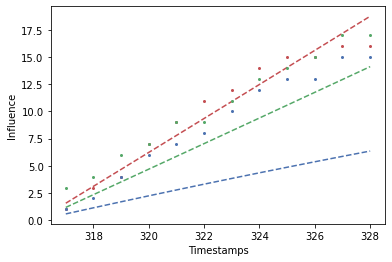

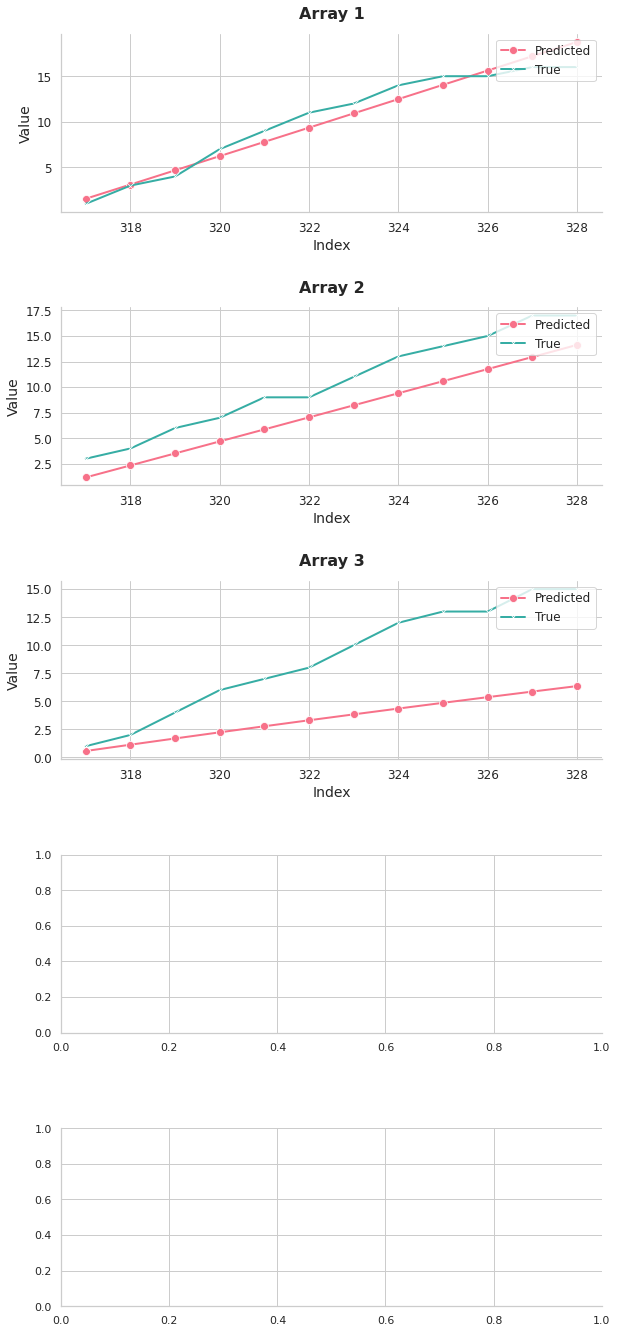

In [281]:
dataset_dropdown = widgets.Dropdown(options=['infectious', 'ht09_contact', 'SFHH', 'tij_InVS15'], description='Dataset', disabled=False, continuous_update=True)
phi_slider = widgets.FloatSlider(min=0.1, max=1, step=0.1, value=0.1, continuous_update=True)
delta_t_slider = widgets.FloatSlider(min=0.1, max=1, step=0.1, value=0.1, continuous_update=True)
beta_slider = widgets.FloatSlider(min=0.1, max=1, step=0.1, value=0.75, continuous_update=True)

w = widgets.interactive(simulate, dataset=dataset_dropdown.value, delta_t=delta_t_slider, phi=phi_slider, beta=beta_slider)
display(w)